# IBM Capstone Project: The Battle of the Neighborhoods

### 1) Install & Import

In [1]:
#!pip install geopy    
#!pip install folium   
#!pip install geocoder

In [2]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import json 
import geocoder 
import requests

from geopy.geocoders import Nominatim

import matplotlib.cm as cm
import matplotlib.colors as colors

from sklearn.cluster import KMeans

import folium 
from folium import plugins
from folium.plugins import HeatMap

from pandas.io.json import json_normalize
import folium
from geopy.geocoders import Nominatim 
import requests

print('DONE!')

DONE!


### 2) Geocoordinates & Neighborhood data 

In [3]:
DENVER = 'Denver, Colorado'

geolocator = Nominatim(user_agent="denver_explorer")

location = geolocator.geocode(DENVER)
latitude = location.latitude
longitude = location.longitude
denver_center = [latitude, longitude]

print('The coordinate of {} are {}, {}.'.format(DENVER, latitude, longitude))

The coordinate of Denver, Colorado are 39.7392364, -104.9848623.


In [4]:
data = pd.read_csv("Book1.csv")

data.rename(columns={'Neighborhoods ':'Neighborhoods'}, inplace=True)

del data['Unnamed: 2']
del data['Unnamed: 3']
del data['Unnamed: 4']
del data['Unnamed: 5']
del data['Unnamed: 6']
del data['Unnamed: 7']

data

,Neighborhoods,Pop
0,Baker,4879
1,Capitol Hill,14708
2,Cherry Creek,5028
3,Cheesman Park,5907
4,City Park,6228
5,Congress Park,24527
6,City Park West,5393
7,Civic Center,1577
8,Lincoln Park,6119
9,North Capitol Hill,5823


In [5]:
def get_latlng(neighborhood):
    lat_lng_coords = None
    while(lat_lng_coords is None):
        g = geocoder.arcgis('{}, {}'.format(neighborhood,DENVER))
        lat_lng_coords = g.latlng
    return lat_lng_coords

coords = [ get_latlng(neighborhood) for neighborhood in data["Neighborhoods"].tolist() ]

df_coords = pd.DataFrame(coords, columns=['Latitude', 'Longitude'])

data['Latitude'] = df_coords['Latitude']
data['Longitude'] = df_coords['Longitude']

data

,Neighborhoods,Pop,Latitude,Longitude
0,Baker,4879,39.71117,-104.99209
1,Capitol Hill,14708,39.73370,-104.97957
2,Cherry Creek,5028,39.71782,-104.94873
3,Cheesman Park,5907,39.72911,-104.96817
4,City Park,6228,39.74379,-104.94825
5,Congress Park,24527,39.73359,-104.95001
6,City Park West,5393,39.74545,-104.96720
7,Civic Center,1577,39.73526,-104.99058
8,Lincoln Park,6119,39.72896,-105.00222
9,North Capitol Hill,5823,39.74425,-104.98108


#### Map

In [162]:
map1 = folium.Map(location=[latitude - .005, longitude + .01], zoom_start=13)

for lat, lng,  neighborhood in zip(data['Latitude'], data['Longitude'], data['Neighborhoods']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=30,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.25,
        parse_html=False).add_to(map1)  
    
map1

### 3) Load Other Venues

In [7]:
CLIENT_ID = 'ZP2VDL0SFT4WVRKLRGCZPKTEL0W1O1Z0LTGN5AJLPAMMO2TJ'
CLIENT_SECRET = 'HKKLXSTGOPEVTM2AQQYQ5STUMP2MX0EZ2JFBPRETKR155ZEW'
VERSION = '20180604'

In [8]:
LIMIT = 100

def getNeighborhoodVenues( latitude, longitude, neighborhood, radius=1000 ):
    tempV = []
    for lat, long, neighborhood in zip(latitude, longitude, neighborhood):

        url = "https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}".format(
            CLIENT_ID,
            CLIENT_SECRET,
            VERSION,
            lat,
            long,
            radius, 
            LIMIT)

        results = requests.get(url).json()["response"]['groups'][0]['items']

        for venue in results:
            tempV.append((
                neighborhood,
                lat, 
                long, 
                venue['venue']['name'], 
                venue['venue']['id'], 
                venue['venue']['location']['lat'], 
                venue['venue']['location']['lng'],  
                venue['venue']['location']['distance'],  
                venue['venue']['categories'][0]['name']))

    tempV = pd.DataFrame(tempV)

    tempV.columns = ['Neighborhoods', 'Latitude', 'Longitude', 'VenueName', 'VenueId', 'VenueLatitude', 'VenueLongitude','VenueDistance','VenueCategory']
            
    return tempV 

In [9]:
venues = getNeighborhoodVenues (data['Latitude'], data['Longitude'], data['Neighborhoods'] )

venues

,Neighborhoods,Latitude,Longitude,VenueName,VenueId,VenueLatitude,VenueLongitude,VenueDistance,VenueCategory
0,Baker,39.71117,-104.99209,Illegal Pete's South Broadway,51cdb21e498e228302912362,39.711768,-104.987187,425,Mexican Restaurant
1,Baker,39.71117,-104.99209,Denver Biscuit Company,527d30c7498e71081051664d,39.713770,-104.987778,469,Breakfast Spot
2,Baker,39.71117,-104.99209,Bardo Coffee House,4bb8fdcab35776b05e7dc901,39.712266,-104.987351,423,Coffee Shop
3,Baker,39.71117,-104.99209,Livwell,519f8fad498ef5973130046c,39.708700,-104.987460,482,Marijuana Dispensary
4,Baker,39.71117,-104.99209,Stranahan's Colorado Whiskey,4b3d1152f964a520398d25e3,39.712253,-104.998576,568,Distillery
...,...,...,...,...,...,...,...,...,...
1054,Union Station,39.75349,-104.99888,P.F. Chang's,4a95dceff964a520192520e3,39.749279,-104.999730,474,Chinese Restaurant
1055,Union Station,39.75349,-104.99888,Colorado Athletic Club - 16th Street,4bb9038f53649c74e49c47fb,39.748789,-104.996578,559,Gym
1056,Union Station,39.75349,-104.99888,Whole Foods Juice Bar,5a4bf31ec4df1d5eb204fa32,39.754437,-105.001569,253,Juice Bar
1057,Union Station,39.75349,-104.99888,Aloy Modern Thai,566b2d8b498e58e746df5629,39.754306,-104.990624,712,Thai Restaurant


### 4) Analysis

#### Restaurant Categories

In [10]:
venues[['VenueId','VenueCategory']].drop_duplicates().groupby('VenueCategory').count() \
[['VenueId']].rename(columns={"VenueId": "Count"}).sort_values(by=['Count'], ascending=False)[:10]

,Count
VenueCategory,
Coffee Shop,44
American Restaurant,35
Mexican Restaurant,31
Bar,31
Pizza Place,24
Italian Restaurant,16
Hotel,16
Park,16
Sandwich Place,16


In [11]:
restaurant_list =['Restaurant', 'Joint', 'Café', 'Place', 'Bar', 'Pub']
Italian_restaurant_list = ['Italian Restaurant', 'Italian ']

venues['RestFlag']=False

for restCat in restaurant_list:
    venues['RestFlag'] = venues['RestFlag'] | venues['VenueCategory'].str.contains(restCat)
    
all_rests = venues[venues['RestFlag'] == True].iloc[:,:-1]

Italian_restaurant = all_rests[ all_rests['VenueCategory'].isin(Italian_restaurant_list) ]
other_restaurants = all_rests[ ~all_rests['VenueCategory'].isin(Italian_restaurant_list) ]

In [13]:
print('Number of restaurants:', len(all_rests['VenueId'].unique()))
print('Number of Italian restaurants:', len(Italian_restaurant['VenueId'].unique()))
print('Percentage of Italian restaurants: {:.2f}%'.format \
                (len(Italian_restaurant['VenueId'].unique()) / len(all_rests['VenueId'].unique()) * 100))

Number of restaurants: 335
Number of Italian restaurants: 16
Percentage of Italian restaurants: 4.78%


#### Graphs

In [15]:
df_rest_counts =  all_rests.groupby(['Neighborhoods']).count().rename(columns={"VenueCategory": "RestaurantCount"})[['RestaurantCount']]

noRestList = list(set(all_rests['Neighborhoods']) - set(all_rests['Neighborhoods']))

if noRestList != []:
    df_rest_counts = df_rest_counts.append (pd.DataFrame( \
                {'Neighborhoods' : noRestList , 'RestaurantCount': [0] * len(noRestList) } ).set_index('Neighborhoods'))

df_rest_counts.reset_index(inplace=True)

df_it_rest_counts =  Italian_restaurant.groupby(['Neighborhoods']).count().rename(columns = \
                {"VenueCategory": "ItalianRestaurantCount"})[['ItalianRestaurantCount']]

noRestList = list(set(all_rests['Neighborhoods']) - set(Italian_restaurant['Neighborhoods']))

if noRestList != []:
    df_it_rest_counts = df_it_rest_counts.append (pd.DataFrame( \
                {'Neighborhoods' : noRestList, 'ItalianRestaurantCount': [0] * len(noRestList) } ).set_index('Neighborhoods'))

df_it_rest_counts.reset_index(inplace=True)
df_rest_counts= df_rest_counts.merge(df_it_rest_counts).set_index('Neighborhoods')
df_rest_counts= df_rest_counts.sort_values(by=['RestaurantCount'],ascending =False)

print('{} neighborhoods do not have any Italian restaurant restaurant.'.format(len(noRestList)))

4 neighborhoods do not have any Italian restaurant restaurant.


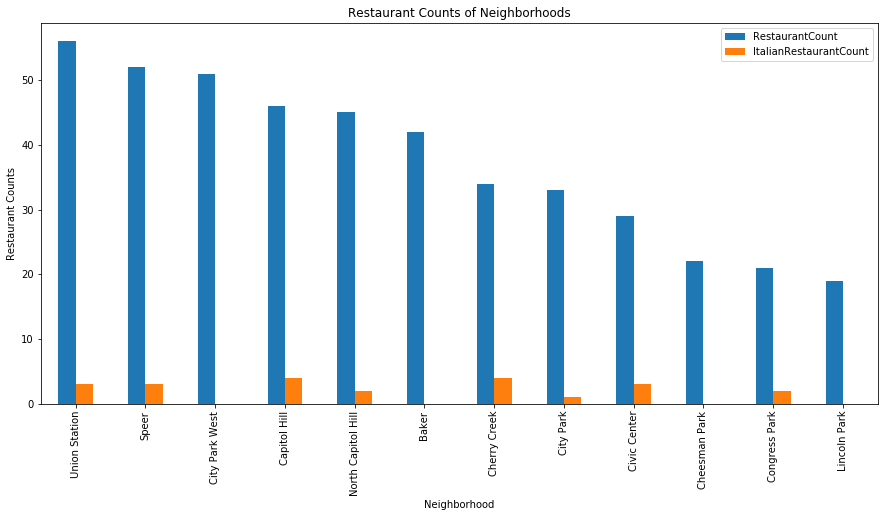

In [62]:
df_rest_counts[['RestaurantCount','ItalianRestaurantCount']].plot(kind='bar',figsize=(15,7))
plt.title('Restaurant Counts of Neighborhoods')
plt.xlabel('Neighborhood')
plt.ylabel('Restaurant Counts')
plt.show()

#### (The next graph is similar to the one above, however it looks at percent of the totals)

In [117]:
A = df_rest_counts[['RestaurantCount','ItalianRestaurantCount']]
B = data[['Neighborhoods', 'Pop']]

#RestaurantCount
tempRC = A['RestaurantCount']
tempRC = (tempRC / sum(tempRC)) * 100

#ItalianRestaurantCount
tempIRC = A['ItalianRestaurantCount']
tempIRC = (tempIRC / sum(tempIRC)) * 100

#Pop
tempPop = B['Pop']
tempPop = (tempPop / sum(tempPop)) * 100

A['RestaurantPercent'] = tempRC
A['ItalianRestaurantPercent'] = tempIRC
B['PopPercent'] = tempPop

#Merging
C = pd.DataFrame()
C = pd.merge(A, B, how='inner', on='Neighborhoods')
C.set_index('Neighborhoods', inplace=True)

C:\Users\Eric\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


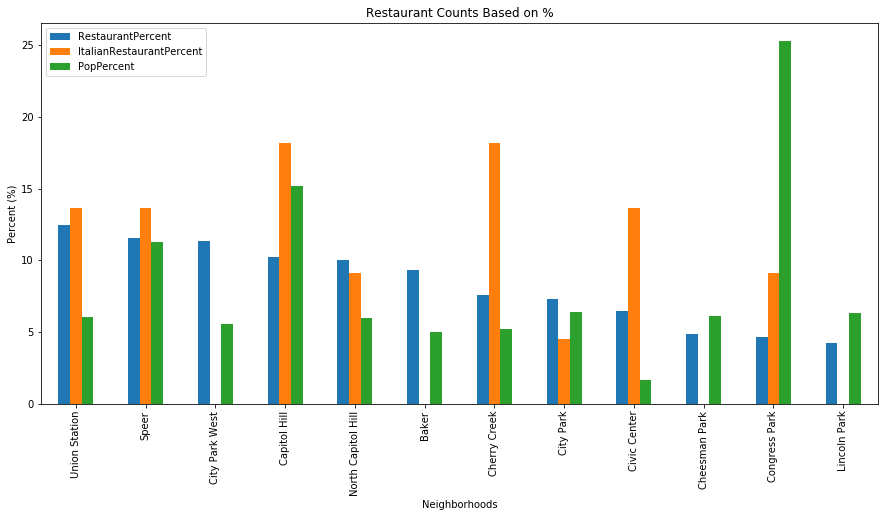

In [118]:
C[['RestaurantPercent','ItalianRestaurantPercent', 'PopPercent']].plot(kind='bar',figsize=(15,7))
plt.title('Restaurant Counts Based on %')
plt.xlabel('Neighborhoods')
plt.ylabel('Percent (%)')
plt.show()

### 5) Discussion

#### Possible Locations

#### Using the graph above, we can narrow down the option to: 
    Congress Park
    Capitol Hill
    City Park West
    Baker
    Cheesman Park
    Lincoln Park

In [148]:
C.loc[['Congress Park', 'Capitol Hill', 'City Park West', 'Baker', 'Cheesman Park', 'Lincoln Park'] \
              , ['RestaurantPercent', 'ItalianRestaurantPercent', 'PopPercent']]

,RestaurantPercent,ItalianRestaurantPercent,PopPercent
Neighborhoods,,,
Congress Park,4.666667,9.090909,25.279833
Capitol Hill,10.222222,18.181818,15.159448
City Park West,11.333333,0.000000,5.558533
Baker,9.333333,0.000000,5.028756
Cheesman Park,4.888889,0.000000,6.088310
Lincoln Park,4.222222,0.000000,6.306817


#### Looking at the table above, we can remove a few more neighborhoods.

    Capitol Hill     - ItalianRestaurantPercent is too high
    City Park West   - RestaurantPercent is too high and PopPercent is lower than other options
    Baker            - RestaurantPercent is too high and PopPercent is lower than other options

In [164]:
C.loc[['Congress Park', 'Cheesman Park', 'Lincoln Park'] \
              , ['RestaurantPercent', 'ItalianRestaurantPercent', 'PopPercent']]

,RestaurantPercent,ItalianRestaurantPercent,PopPercent
Neighborhoods,,,
Congress Park,4.666667,9.090909,25.279833
Cheesman Park,4.888889,0.000000,6.088310
Lincoln Park,4.222222,0.000000,6.306817



#### I'm indifferent about the last three options.

    Congress Park does have other Italian restaurants. However, it also has the largest population percentage of all of the neighborhoods.

    Cheesman Park and Lincoln Park are very similar. Both have no other Italian restaurants and almost identical population percentages.

In [163]:
dfm2 = data.loc[ [5, 3, 8] , : ]

map2 = folium.Map(location=[latitude - .005, longitude + .01], zoom_start=14)

for lat, lng, neighborhood in zip(dfm2['Latitude'], dfm2['Longitude'], dfm2['Neighborhoods']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=100,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.25,
        parse_html=False).add_to(map2)
map2